In [1]:
import locale
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Palatino'
fig_path = r'/Users/leonbecker/Library/CloudStorage/OneDrive-UniversitätWürzburg/Universität Würzburg/Master Information-Systems/Thesis/LaTex/graphics/'
plt.rcParams['path.simplify'] = True
locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

In [ ]:
wine_type_ids = {
    1: 'Rotwein',
    2: 'Weißwein',
    3: 'Schaumwein',
    4: 'Rosé',
    24: 'Likörwein',
    7: 'Dessertwein'
}

In [ ]:
con_wine = sqlite3.connect('../database/wine_distinct.db')
df_wine = pd.read_sql_query("SELECT * from wine_distinct", con_wine)
df_wine.head()

In [ ]:
for index in df_wine.index:
    df_wine.at[index, 'type_name'] = wine_type_ids[df_wine.loc[index, 'type_id']]

In [ ]:
ax = df_wine.country.value_counts().head(n=10).plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'top_10_producer_countries.pdf')

In [ ]:
ax = df_wine.type_name.value_counts().plot(
    kind='bar',
    color='black',
    zorder=3
)
plt.grid(zorder=0, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_path + 'wine_type_distribution.pdf')

In [ ]:
ax = df_wine.average_rating.plot(
    kind='box'
)
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
plt.savefig(fig_path + 'average_rating.pdf')

In [ ]:
ax = df_wine.boxplot(by='type_name', column='average_rating', rot=45)
ax.set_title('')
plt.suptitle('')
ax.set_xlabel('')
plt.tight_layout()
plt.xticks(rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig(fig_path + 'average_rating_by_wine.pdf')

In [ ]:
top_10_countries = df_wine.country.value_counts().head(n=10).index

In [ ]:
plt.grid(zorder=0)
ax = sb.violinplot(
    data=df_wine[df_wine.country.isin(top_10_countries)],
    y='average_rating',
    x='country',
    #palette=['w','w','w','w', 'w','w','w','w', 'w', 'w'],
    zorder=3
)
# plt.grid(axis='y')
plt.xticks(rotation=45)
plt.ylabel(None)
plt.xlabel(None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path + 'top_10_ratings_for_countries.pdf')

# Reviews

In [3]:
con_rev = sqlite3.connect('../database/review.db')
df_rev = pd.read_sql_query("SELECT * from review", con_rev)
df_rev.head()

,index,id,wine_id,rating,note,created_at,likes_count,comments_count,scan_image_path,user_id,note_length,len_code
0,0,66,1154225,3.5,Notevole differenza tra naso e palato. Con spi...,1969-12-31T23:00:01.000Z,1.0,0.0,images.vivino.com/labels/01dls5mm5nr12.jpg,4683161,18,it
1,1,2996,1652,5.0,Toskaner auf absoluten Top-Niveau. Einer der b...,2011-04-17T19:53:55.000Z,1.0,2.0,images.vivino.com/thumbs/LtqnB-H2QFmN6ixL3FQcd...,24294,18,de
2,2,3975,1101258,4.0,Excellent full bodied wine,2011-07-19T21:21:22.000Z,2.0,1.0,images.vivino.com/labels/1309631550_2382.jpg,32547,4,en
3,3,4202,76378,5.0,The Real price at phillipson is around 1299 dk...,2011-08-06T20:52:53.000Z,0.0,1.0,images.vivino.com/labels/1311959128_1819.jpg,48500,39,en
4,4,4261,1231210,5.0,"Clean, crisp and full of nuance and elegance, ...",2011-08-11T08:06:39.000Z,3.0,1.0,images.vivino.com/labels/1312622458_6592.jpg,53601,17,en


In [ ]:
df_rev = df_rev.iloc[1:]

In [ ]:
ax = df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)]).count()['index'].cumsum().plot()

In [ ]:
#convert date column to datetime and subtract one week
df_rev['created_at'] = pd.to_datetime(df_rev['created_at']) - pd.to_timedelta(7, unit='d')

#calculate sum of values, grouped by week
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')]).count()['index'].cumsum().plot()

In [ ]:
ax = df_rev.groupby([pd.Grouper(key='created_at', freq='W')])['index'].count().cumsum().plot()

In [ ]:
df_rev.groupby([pd.to_datetime(df_rev.created_at).dt.date.drop(0)])

In [ ]:
print(ax)

In [ ]:
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.get_figure().tight_layout()
ax.get_figure().savefig(fig_path + '/cumsum_reviews_month.pdf')

In [ ]:
pd.to_datetime(df_rev.created_at).dt.date.drop(0, inplace=True)

In [ ]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
data_var

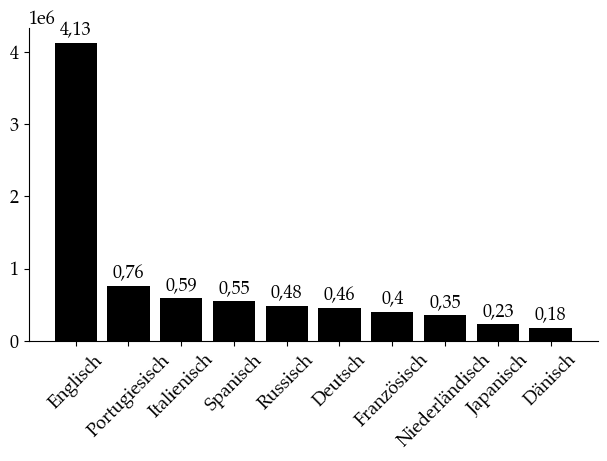

In [46]:
data_var = df_rev.len_code.value_counts().head(n=10)
data_var.index = ['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                  'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch']
fig, ax = plt.subplots()
ax.bar(
    x=data_var.index,
    height=data_var.values,
    color='black'
)
plt.xticks(rotation=45)
bars = ax.bar(data_var.index,
              data_var.values ,
              color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
container = ax.containers[0]
ax.bar_label(container, labels=[str.replace(str(np.round(x / 1000000, decimals=2)), '.', ',')for x in container.datavalues], padding=2)
# ax.bar_label(bars, padding=3)
fig.tight_layout()
fig.savefig(fig_path + 'language_distribution.pdf')

In [47]:
top_10_order = list(df_rev.len_code.value_counts().head(n=10).index)
top_10_order

['en', 'pt', 'it', 'es', 'ru', 'de', 'fr', 'nl', 'ja', 'da']

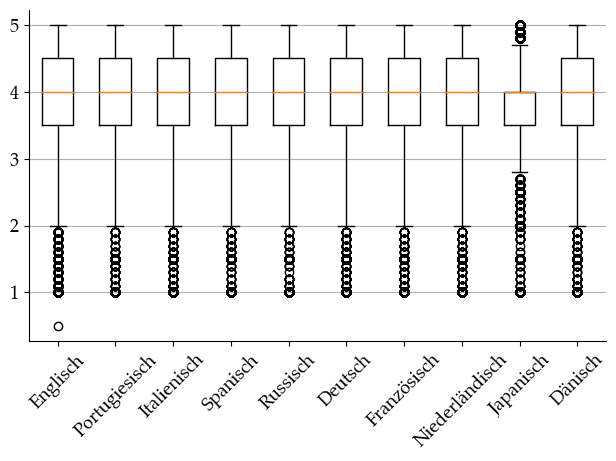

In [48]:
fig, ax = plt.subplots()
df = df_rev[df_rev.len_code.isin(top_10_order)][['len_code', 'rating']]
for position, column in enumerate(top_10_order):
    plot_var = ax.boxplot(df[df.len_code == column].rating, positions=[position], widths=0.55)

ax.set_xticks(range(position + 1))
ax.set_xticklabels(top_10_order)
# ax.set_xlim(xmin=-0.5)
ax.set_xticklabels(['Englisch', 'Portugiesisch', 'Italienisch', 'Spanisch', 'Russisch',
                    'Deutsch', 'Französisch', 'Niederländisch', 'Japanisch', 'Dänisch'])
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
plt.tight_layout()
plt.show()
fig.savefig(fig_path + 'top_10_review_count_ratings.png', dpi=300)

In [49]:
con_rev_sent = sqlite3.connect('../database/review_en_sentiment.db')
df_rev_sent = pd.read_sql_query("SELECT id, rating, sentiment from review_en_sentiment", con_rev_sent)
df_rev_sent.head()

,id,rating,sentiment
0,3975,4.0,0.938549
1,4202,5.0,0.576068
2,4261,5.0,0.982237
3,4264,4.0,0.576195
4,4354,4.0,0.736812


In [50]:
n = 25000
df = df_rev_sent.sample(n=n)

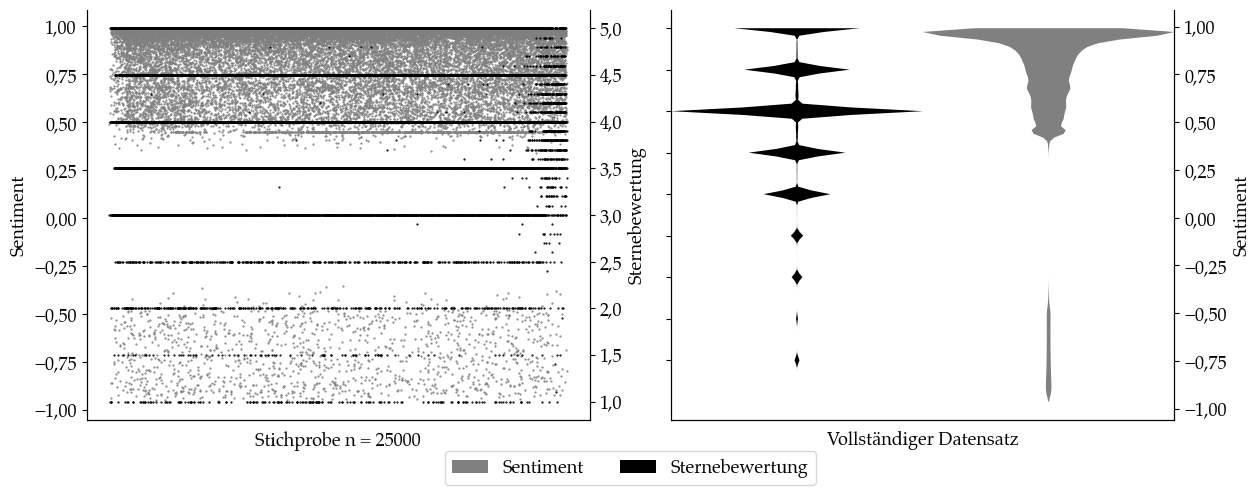

In [51]:
from matplotlib.patches import Patch

# Initialize subplots
fig, (ax1_1, ax2_1) = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))

# First plot
ax1_2 = ax1_1.twinx()
ax1_1.scatter(x=df.id, y=df.sentiment, c='grey', s=0.3)
ax1_2.scatter(x=df.id, y=df.rating, c='black', s=0.3)
ax1_1.set_ylabel('Sentiment')
ax1_2.set_ylabel('Sternebewertung')
ax1_2.set_xticks([])
ax1_1.set_xticklabels([])
ax1_1.set_xlabel('Stichprobe n = ' + str(n))
ax1_1.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)
# fig.tight_layout()
# fig.savefig(fig_path + 'sentiment_rating.png', dpi=300)

# Second plot
ax2_2 = ax2_1.twinx()
p1 = ax2_1.violinplot(df_rev_sent.rating, positions=[0.5], showextrema=False)
p2 = ax2_2.violinplot(df_rev_sent.sentiment, positions=[1], showextrema=False)

for pc in p1['bodies']:
    pc.set_facecolor('black')
    pc.set_alpha(1)
for pc in p2['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(1)
ax2_1.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

# ax2_1.legend()
ax2_1.set_xlim(0.25, 1.25)
ax2_1.set_xticks([])
ax2_1.set_yticks([ 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax2_1.set_yticklabels([])
ax2_2.set_ylabel('Sentiment')
ax2_1.set_xlabel('Vollständiger Datensatz')

legened_elements = [
    Patch(facecolor='grey', label='Sentiment'),
    Patch(facecolor='black', label='Sternebewertung')
]

fig.legend(handles=legened_elements, loc='lower center',bbox_to_anchor=(0.25, -0.05, 0.5, 0.5), ncol=2)
fig.tight_layout()
fig.savefig(fig_path + 'sentiment_rating.pdf',bbox_inches='tight')